In [1]:
pip install tfrecord

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 3.2 MB/s eta 0:00:00
  Created wheel for tfrecord: filename=tfrecord-1.14.6-py3-none-any.whl size=14834 sha256=168b50677e45335a7b6de2f3dd4704d0055eb469e729da56c6a05093407ca58b
  Stored in directory: /root/.cache/pip/wheels/bf/00/32/db9abfb84508d182806ca91e7391ca865d5037e585c088e8e6
Successfully built tfrecord
Note: you may need to restart the kernel to use updated packages.


In [2]:
import io
import math
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import IterableDataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import timm

try:
    import tfrecord
except ModuleNotFoundError:
    tfrecord = None
    print("Warning: tfrecord not installed.")

from tqdm.auto import tqdm

plt.style.use('seaborn-v0_8')


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
class ModelConfig:
    base_path = Path('/kaggle/input/tpu-getting-started')
    tfrecord_dir = base_path / 'tfrecords-jpeg-512x512'
    train_dir = tfrecord_dir / 'train'
    val_dir = tfrecord_dir / 'val'
    test_dir = tfrecord_dir / 'test'

    image_size = (384, 384)
    num_classes = 104

    batch_size = 16
    val_batch_size = 64
    test_batch_size = 64
    epochs = 10

    learning_rate = 3e-4
    min_lr = 1e-6
    weight_decay = 1e-5
    grad_clip = 1.0

    num_workers = 1
    seed = 2235

    model_name = 'swin_large_patch4_window12_384'
    drop_rate = 0.214
    drop_path_rate = 0.118
    use_amp = True

    output_dir = Path('/kaggle/working')
    model_path = output_dir / 'best_model.pt'
    submission_path = output_dir / 'submission.csv'

    train_limit = None
    val_limit = None
    test_limit = None

    classes = [
        'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'wild geranium',
        'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
        'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
        'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
        'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
        'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william',
        'carnation', 'garden phlox', 'love in the mist', 'cosmos', 'alpine sea holly',
        'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose',
        'barberton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue',
        'wallflower', 'marigold', 'buttercup', 'daisy', 'common dandelion',
        'petunia', 'wild pansy', 'primula', 'sunflower', 'lilac hibiscus',
        'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
        'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy',
        'osteospermum', 'spring crocus', 'iris', 'windflower', 'tree poppy',
        'gazania', 'azalea', 'water lily', 'rose', 'thorn apple',
        'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium',
        'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose',
        'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily',
        'hippeastrum ', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea',
        'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower',
        'trumpet creeper', 'blackberry lily', 'common tulip', 'wild rose'
    ]


ModelConfig.output_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def set_seed(seed: int = ModelConfig.seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed()


In [4]:
use_cuda = torch.cuda.is_available()
num_gpus = torch.cuda.device_count() if use_cuda else 0
device = torch.device('cuda' if use_cuda else 'cpu')


def set_seed(seed: int = ModelConfig.seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


set_seed()


In [5]:
class AverageMeter:

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val: float, n: int = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count else 0.0


def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()


def compute_classification_metrics(preds: np.ndarray, labels: np.ndarray):
    accuracy = (preds == labels).mean()
    f1 = f1_score(labels, preds, labels=np.arange(ModelConfig.num_classes), average='macro')
    precision = precision_score(labels, preds, labels=np.arange(ModelConfig.num_classes), average='macro')
    recall = recall_score(labels, preds, labels=np.arange(ModelConfig.num_classes), average='macro')
    cmat = confusion_matrix(labels, preds, labels=np.arange(ModelConfig.num_classes))
    return accuracy, f1, precision, recall, cmat


def plot_training_curves(history):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(history['train_loss'], label='train')
    axes[0].plot(history['val_loss'], label='val')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('epoch')
    axes[0].legend()

    axes[1].plot(history['train_acc'], label='train')
    axes[1].plot(history['val_acc'], label='val')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].legend()

    axes[2].plot(history['lr'])
    axes[2].set_title('Learning Rate')
    axes[2].set_xlabel('epoch')

    plt.show()


def show_confusion_matrix(cmat: np.ndarray, title_suffix: str = ''):
    fig, ax = plt.subplots(figsize=(14, 12))
    cax = ax.imshow(cmat, interpolation='nearest', cmap='Reds')
    fig.colorbar(cax)
    ax.set_title(f'Confusion Matrix {title_suffix}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.show()


In [6]:
import re


def get_tfrecord_files(directory: Path):
    files = sorted(str(p) for p in directory.glob('*.tfrec'))
    if not files:
        raise FileNotFoundError(f'No TFRecord files found in {directory}')
    return files


def count_data_items(filenames):
    pattern = re.compile(r'-([0-9]*)\.tfrec$')
    total = 0
    for fname in filenames:
        match = pattern.search(fname)
        if match:
            total += int(match.group(1))
    return total


def get_train_transforms():
    return transforms.Compose([
        transforms.RandomResizedCrop(ModelConfig.image_size, scale=(0.7, 1.0), ratio=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(p=0.618),
        transforms.RandomVerticalFlip(p=0.314),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.RandomRotation(degrees=20),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
    ])


def get_eval_transforms():
    return transforms.Compose([
        transforms.Resize(ModelConfig.image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


class FlowerTFRecordDataset(IterableDataset):
    def __init__(self, filenames, labeled=True, transform=None, seed=ModelConfig.seed, limit=None):
        self.filenames = list(filenames)
        self.labeled = labeled
        self.transform = transform
        self.seed = seed
        self.limit = limit
        self.epoch = 0
        total_items = count_data_items(self.filenames)
        self.num_samples = min(total_items, limit) if limit is not None else total_items

    def set_epoch(self, epoch: int):
        self.epoch = epoch

    def __len__(self):
        return self.num_samples

    def _shuffle_files(self):
        rng = random.Random(self.seed + self.epoch)
        files = self.filenames.copy()
        rng.shuffle(files)
        return files

    def _shuffle_records(self, records, *, fname):
        rng = random.Random(self.seed + self.epoch + hash(fname) % 10_000)
        records = list(records)
        rng.shuffle(records)
        return records

    def __iter__(self):
        files = self._shuffle_files()
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is not None:
            files = files[worker_info.id :: worker_info.num_workers]

        produced = 0
        for fname in files:
            if self.limit is not None and produced >= self.limit:
                break

            try:
                records = tfrecord.tfrecord_loader(fname, None, None)
            except Exception as exc:
                print(f'Warning: failed to read {fname}: {exc}')
                continue

            for record in self._shuffle_records(records, fname=fname):
                if self.limit is not None and produced >= self.limit:
                    break

                image_bytes = record['image']
                image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
                if self.transform is not None:
                    image = self.transform(image)

                if self.labeled:
                    label_raw = record['class']
                    if isinstance(label_raw, np.ndarray):
                        label = int(label_raw.reshape(-1)[0])
                    elif isinstance(label_raw, (list, tuple)):
                        label = int(label_raw[0])
                    else:
                        label = int(label_raw)
                    yield image, label
                else:
                    image_id = record.get('id', '')
                    if isinstance(image_id, bytes):
                        image_id = image_id.decode()
                    yield image, image_id

                produced += 1


def build_loader(directory: Path, *, labeled: bool, transform, batch_size: int, limit=None):
    filenames = get_tfrecord_files(directory)
    dataset = FlowerTFRecordDataset(filenames, labeled=labeled, transform=transform, limit=limit)

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=ModelConfig.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    return loader, dataset


def get_loaders():
    train_loader, _ = build_loader(
        ModelConfig.train_dir,
        labeled=True,
        transform=get_train_transforms(),
        batch_size=ModelConfig.batch_size,
        limit=ModelConfig.train_limit,
    )

    val_loader, _ = build_loader(
        ModelConfig.val_dir,
        labeled=True,
        transform=get_eval_transforms(),
        batch_size=ModelConfig.val_batch_size,
        limit=ModelConfig.val_limit,
    )

    return train_loader, val_loader


def get_test_loader():
    test_loader, _ = build_loader(
        ModelConfig.test_dir,
        labeled=False,
        transform=get_eval_transforms(),
        batch_size=ModelConfig.test_batch_size,
        limit=ModelConfig.test_limit,
    )
    return test_loader


In [7]:
def build_model():
    model = timm.create_model(
        ModelConfig.model_name,
        pretrained=True,
        num_classes=ModelConfig.num_classes,
        drop_rate=ModelConfig.drop_rate,
        drop_path_rate=ModelConfig.drop_path_rate,
    )
    return model


def create_optimizer(model):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=ModelConfig.learning_rate,
        weight_decay=ModelConfig.weight_decay,
    )
    return optimizer


def create_scheduler(optimizer):
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=ModelConfig.epochs,
        eta_min=ModelConfig.min_lr,
    )
    return scheduler


In [8]:
def run_epoch(loader, model, criterion, optimizer=None, scaler=None, epoch=0, training=True):
    if training and hasattr(loader.dataset, 'set_epoch'):
        loader.dataset.set_epoch(epoch)

    if training:
        model.train()
    else:
        model.eval()

    losses = AverageMeter()
    accuracies = AverageMeter()

    total_steps = math.ceil(len(loader.dataset) / loader.batch_size)

    pbar = tqdm(loader, total=total_steps, leave=False)
    pbar.set_description(f"Epoch {epoch + 1} [{'train' if training else 'val'}]")

    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.set_grad_enabled(training):
            with autocast(enabled=scaler is not None and scaler.is_enabled()):
                outputs = model(images)
                loss = criterion(outputs, targets)

        batch_size = targets.size(0)
        if training and optimizer is not None:
            optimizer.zero_grad(set_to_none=True)
            if scaler is not None and scaler.is_enabled():
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), ModelConfig.grad_clip)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), ModelConfig.grad_clip)
                optimizer.step()

        acc = accuracy_from_logits(outputs.detach(), targets)
        losses.update(loss.item(), batch_size)
        accuracies.update(acc, batch_size)

        pbar.set_postfix({
            'loss': f'{losses.avg:.4f}',
            'acc': f'{accuracies.avg:.4f}',
            'lr': optimizer.param_groups[0]['lr'] if optimizer is not None else 0.0,
        })

    return losses.avg, accuracies.avg


def train_model():
    train_loader, val_loader = get_loaders()

    model = build_model().to(device)
    if use_cuda and num_gpus > 1:
        model = nn.DataParallel(model)
        print(f'Using DataParallel on {num_gpus} GPUs')
    criterion = nn.CrossEntropyLoss()
    optimizer = create_optimizer(model)
    scheduler = create_scheduler(optimizer)
    scaler = GradScaler(enabled=ModelConfig.use_amp and device.type == 'cuda')

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': [],
    }

    best_val_acc = 0.0

    for epoch in range(ModelConfig.epochs):
        train_loss, train_acc = run_epoch(
            train_loader,
            model,
            criterion,
            optimizer=optimizer,
            scaler=scaler,
            epoch=epoch,
            training=True,
        )

        val_loss, val_acc = run_epoch(
            val_loader,
            model,
            criterion,
            optimizer=None,
            scaler=None,
            epoch=epoch,
            training=False,
        )

        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print(f"Epoch {epoch + 1}/{ModelConfig.epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, lr={current_lr:.2e}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_to_save = model.module if isinstance(model, nn.DataParallel) else model
            torch.save({'model_state_dict': model_to_save.state_dict(), 'val_acc': best_val_acc}, ModelConfig.model_path)
            print(f"  ✓ New best model saved (val_acc={best_val_acc:.4f})")

    return model, history, best_val_acc



In [9]:
@torch.no_grad()
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    pbar = tqdm(loader, leave=False)
    pbar.set_description('Evaluating')

    for images, labels in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    preds = np.concatenate(all_preds)
    labels = np.concatenate(all_labels)

    accuracy, f1, precision, recall, cmat = compute_classification_metrics(preds, labels)
    return preds, labels, accuracy, f1, precision, recall, cmat


@torch.no_grad()
def generate_submission(model, loader):
    model.eval()
    all_preds = []
    all_ids = []

    pbar = tqdm(loader, leave=False)
    pbar.set_description('Predicting test')

    for images, image_ids in pbar:
        images = images.to(device, non_blocking=True)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_ids.extend(image_ids)

    submission = pd.DataFrame({'id': all_ids, 'label': all_preds})
    submission.to_csv(ModelConfig.submission_path, index=False)
    print(f'Submission saved to {ModelConfig.submission_path}')
    return submission


model.safetensors:   0%|          | 0.00/801M [00:00<?, ?B/s]

Using DataParallel on 2 GPUs


/tmp/ipykernel_24/4034894786.py:63: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=ModelConfig.use_amp and device.type == 'cuda')


  0%|          | 0/798 [00:00<?, ?it/s]

/tmp/ipykernel_24/4034894786.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None and scaler.is_enabled()):


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 1/10: train_loss=0.7951, train_acc=0.8223, val_loss=0.3002, val_acc=0.9297, lr=2.93e-04
  ✓ New best model saved (val_acc=0.9297)


  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 2/10: train_loss=0.3664, train_acc=0.9095, val_loss=0.2688, val_acc=0.9316, lr=2.71e-04
  ✓ New best model saved (val_acc=0.9316)


  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 3/10: train_loss=0.2580, train_acc=0.9419, val_loss=0.3229, val_acc=0.9515, lr=2.38e-04
  ✓ New best model saved (val_acc=0.9515)


  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 4/10: train_loss=0.1567, train_acc=0.9716, val_loss=0.3971, val_acc=0.9504, lr=1.97e-04


  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 5/10: train_loss=0.2532, train_acc=0.9587, val_loss=0.4569, val_acc=0.9370, lr=1.50e-04


  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 6/10: train_loss=0.1381, train_acc=0.9763, val_loss=0.4868, val_acc=0.9531, lr=1.04e-04
  ✓ New best model saved (val_acc=0.9531)


  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 7/10: train_loss=0.0613, train_acc=0.9893, val_loss=0.4117, val_acc=0.9650, lr=6.26e-05
  ✓ New best model saved (val_acc=0.9650)


  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 8/10: train_loss=0.0263, train_acc=0.9952, val_loss=0.4441, val_acc=0.9661, lr=2.96e-05
  ✓ New best model saved (val_acc=0.9661)


  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 9/10: train_loss=0.0179, train_acc=0.9973, val_loss=0.4143, val_acc=0.9701, lr=8.32e-06
  ✓ New best model saved (val_acc=0.9701)


  0%|          | 0/798 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 10/10: train_loss=0.0078, train_acc=0.9987, val_loss=0.4186, val_acc=0.9690, lr=1.00e-06


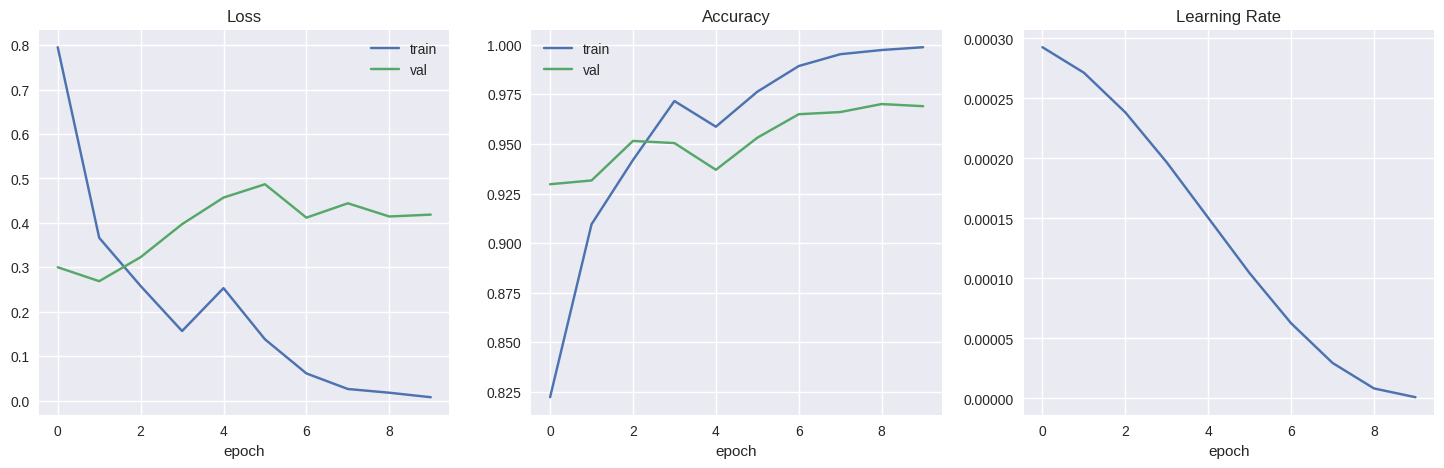

Best validation accuracy: 0.9701
CPU times: user 2h 45min 7s, sys: 43min 48s, total: 3h 28min 55s
Wall time: 2h 32min 19s


In [10]:
%%time

model, history, best_val_acc = train_model()
plot_training_curves(history)
print(f'Best validation accuracy: {best_val_acc:.4f}')


Loaded best checkpoint with val_acc=0.9701


  0%|          | 0/58 [00:00<?, ?it/s]

Validation accuracy: 0.9701, F1: 0.9638, precision: 0.9645, recall: 0.9663


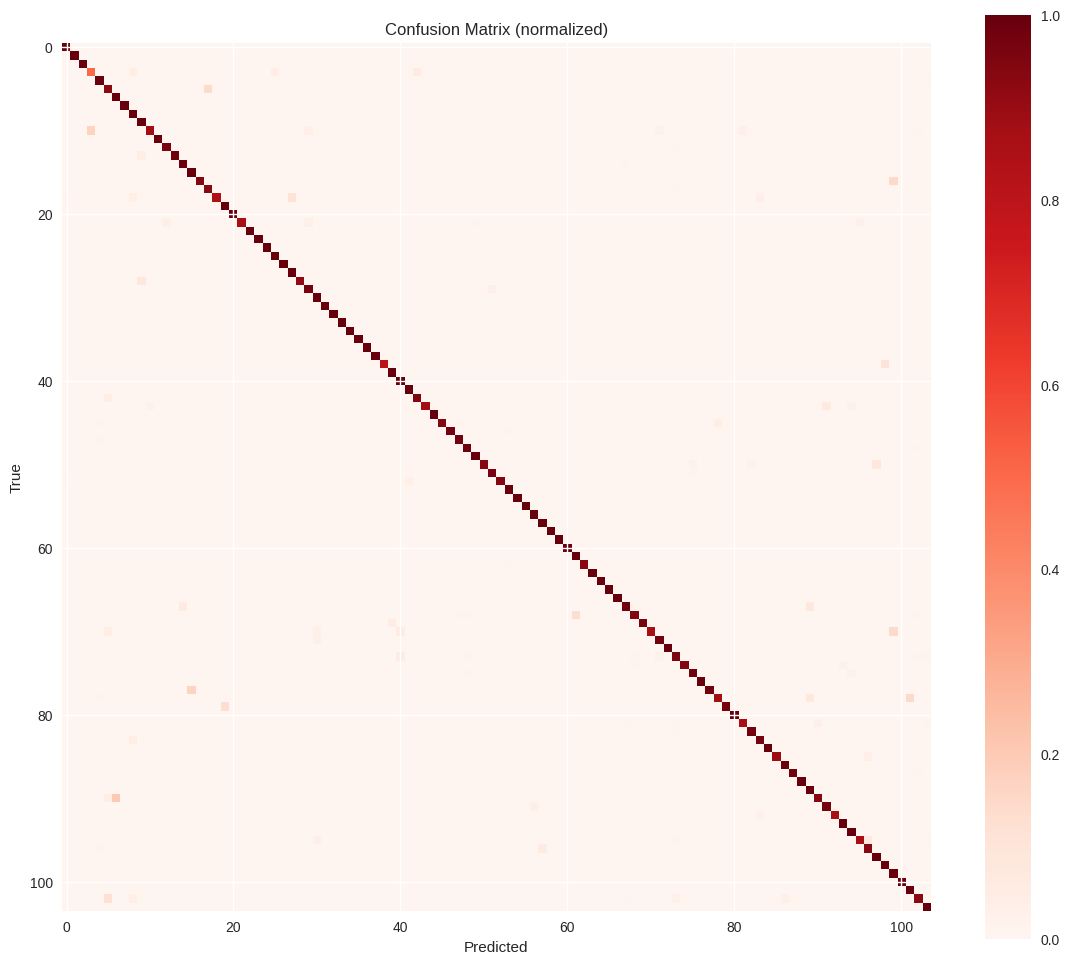

In [11]:
checkpoint = torch.load(ModelConfig.model_path, map_location=device)
base_model = build_model()
base_model.load_state_dict(checkpoint['model_state_dict'])
if use_cuda and num_gpus > 1:
    model = nn.DataParallel(base_model).to(device)
else:
    model = base_model.to(device)
print(f"Loaded best checkpoint with val_acc={checkpoint['val_acc']:.4f}")

_, val_loader = get_loaders()
preds, labels, acc, f1, precision, recall, cmat = evaluate_model(model, val_loader)
print(f'Validation accuracy: {acc:.4f}, F1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}')

cmat_norm = (cmat.T / cmat.sum(axis=1, keepdims=True)).T
show_confusion_matrix(cmat_norm, title_suffix='(normalized)')


In [12]:
test_loader = get_test_loader()
submission = generate_submission(model, test_loader)
submission.head()


  0%|          | 0/116 [00:00<?, ?it/s]

Submission saved to /kaggle/working/submission.csv


,id,label
0,6449727d1,61
1,e8a1d04f0,103
2,f98f94bac,51
3,df17daf47,83
4,ac1156cb1,88
